# KICK-START OWN BUSINESS @TORONTO
#### *Coursera Capstone Project*

## Introduction
 
  ### To find out the best business that can be choosen by the investore to startbin Toronto
 
 We will start by scraping the Wikipedia page List of postal codes of Canada: M to get a list of neighborhoods in Toronto. Then we will find the latitude and longitude of each neighborhood. Next, we will use the Foursquare API to explore the neighborhoods. We will get the LEAST common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters.We will merge the population data of toronto city with this data set and we will use the k-means clustering algorithm to complete this task. Finally, we will use the Folium library to visualize the neighborhoods in Toronto and their emerging clusters and display the list of business opations that investor can choose in bar chart.


## Table of Contents ##

1. Acquire Data

2. Merge the Data

3. Explore Neighborhoods in Toronto

4. Analyze Each Neighborhood

5. Cluster Neighborhoods

6. Examine Clusters


First we will download all the necessarry packages and libraries used in this project

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

!conda install -c conda-forge bs4 --yes

!conda install -c anaconda lxml --yes

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt

print("Installing package for bs4, lxml file and geopy is done")
print("Importing libraries finished")

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be UPDATED:

  ca-certificates      anaconda::ca-certificates-2020.1.1-0 --> conda-forge::ca-certificates-2020.4.5.1-hecc5488_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi               anaconda::certifi-2020.4.5.1-py36_0 --> conda-forge::certifi-2020.4.5.1-py36h9f0ad1d_0
  openssl                anaconda::openssl-1.1.1-h7b6447c_0 --> conda-forge::openssl-1.1.1f-h516909a_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - lxml


The following packages will be UPDA

## 1. Acquire Data
We will scrape the list of Toronto neighborhoods from the Wikipedia page List of postal codes of Canada: M. Postal codes beginning with M are located within the city of Toronto. 

In [2]:
#to read table from wikipedia page

res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
data=df[0]  #store in data frame
data.head(10)

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government
7,M8A,Not assigned,NaN
8,M9A,Etobicoke,Islington Avenue
9,M1B,Scarborough,Malvern / Rouge


In [3]:
data=data[data.Borough !='Not assigned']   #toremove all Not assigned values
data['Neighborhood']=data['Neighborhood'].replace('/',',',regex=True)   #to replcae / with ,

data.head(10)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park , Harbourfront"
5,M6A,North York,"Lawrence Manor , Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"
8,M9A,Etobicoke,Islington Avenue
9,M1B,Scarborough,"Malvern , Rouge"
11,M3B,North York,Don Mills
12,M4B,East York,"Parkview Hill , Woodbine Gardens"
13,M5B,Downtown Toronto,"Garden District, Ryerson"


In [4]:
data.shape   #shape of the data will be displayed

(103, 3)

next we will read the population data from www12.statcan.gc.ca website and store in dataframe

In [5]:
res = requests.get("https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&SR=1&S=22&O=A&RPP=9999&PR=0")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
pop=df[0]   #store in data frame

pop.drop(pop.index[[0,1]],inplace=True)    #deletion of unwanted rows
#change columns name to shorten the names
pop.rename(columns={'Geographic name':'Geographic Code','Population,2016':'Population','Total private dwellings, 2016':'Total dwellings','Private dwellings occupied by usual residents, 2016':'Occupied dwellings'},inplace=True)#renaming rows
pop.drop(columns={'Total dwellings'},inplace=True)

pop.head()

,Geographic Code,"Population, 2016",Occupied dwellings
2,A0A,46587.0,19426.0
3,A0B,19792.0,8792.0
4,A0C,12587.0,5606.0
5,A0E,22294.0,9603.0
6,A0G,35266.0,15200.0


Last data that we need to acquire is geo spatial data i.e longitude and latitude values of all postal codes

In [6]:
#reading data from csv file
lat_data=pd.read_csv('http://cocl.us/Geospatial_data')
lat_data.head()


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


##      2. Merging Data

First we will merge Data frame containing data of neighbours of toronto with the geo spatial data we acquired

In [7]:
#change index columns for merging
lat_data.set_index("Postal Code", inplace=True)
data.set_index("Postal code", inplace=True)


In [8]:
#merging two dataframes based on index 

merged = data.merge(lat_data, left_index=True, right_index=True, how='inner')
merged.reset_index(inplace=True)
merged=merged.rename({'index':'Postal Code'},axis=1)   
merged.head()


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494


In [9]:
#change all Borough to Toronto that contains toronto word in it for easy processing
        
value='Toronto'
for i in merged.index.values:
    if(value in merged.loc[i,'Borough']):
        merged.loc[i,'Borough']=value      
merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494


In [10]:
#fetching only toronto neighbours since we are intrested in only Toronto in this project

toronto_data = merged[merged['Borough'] == 'Toronto'].reset_index(drop=True)
toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
1,M7A,Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494
2,M5B,Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Toronto,St. James Town,43.651494,-79.375418
4,M4E,Toronto,The Beaches,43.676357,-79.293031


Now we will merge the toronto_data frame with the population data we fetched and stored in data frame named pop

In [11]:
toronto_data = toronto_data.join(pop.set_index('Geographic Code'), on = 'Postal Code')
toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,"Population, 2016",Occupied dwellings
0,M5A,Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,41078.0,22333.0
1,M7A,Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,10.0,5.0
2,M5B,Toronto,"Garden District, Ryerson",43.657162,-79.378937,12785.0,7058.0
3,M5C,Toronto,St. James Town,43.651494,-79.375418,2951.0,1721.0
4,M4E,Toronto,The Beaches,43.676357,-79.293031,25044.0,10784.0


## 3. Explore Neighborhoods in Toronto

We will fetch the longitude and latitude value of torrento using geocode API and generate a map of toronto with all the neighboures in our data set placed in the map.

In [12]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [13]:
# create map of toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Now we will use Foursqaure API go get all the venues within radius of 500 and limit of 100
for that initially we need to establish a connection with foursqaure with our credentials

In [14]:
CLIENT_ID = '4UQKF1VNK1U5TOKBML3SFX2FWQGVEWDUK00TL34FA0TDV31W' #  Foursquare ID
CLIENT_SECRET = 'DKF0KWXPWV1IC5NDCASYUNB5F5MLUXATG2QP02IHL05SMKQX' #  Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4UQKF1VNK1U5TOKBML3SFX2FWQGVEWDUK00TL34FA0TDV31W
CLIENT_SECRET:DKF0KWXPWV1IC5NDCASYUNB5F5MLUXATG2QP02IHL05SMKQX


We will define a function to get all nearby venues since we need to call this fuctions for each neighboured

In [15]:
LIMIT = 100
radius = 500


#to find all the venues near all the neighbours of toronto within radius 500
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
# We fetch all the venues and save them in toronto_venue data frame

toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )


Regent Park , Harbourfront
Queen's Park , Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond , Adelaide , King
Dufferin , Dovercourt Village
Harbourfront East , Union Station , Toronto Islands
Little Portugal , Trinity
The Danforth West , Riverdale
Toronto Dominion Centre , Design Exchange
Brockton , Parkdale Village , Exhibition Place
India Bazaar , The Beaches West
Commerce Court , Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park , The Junction South
North Toronto West
The Annex , North Midtown , Yorkville
Parkdale , Roncesvalles
Davisville
University of Toronto , Harbord
Runnymede , Swansea
Moore Park , Summerhill East
Kensington Market , Chinatown , Grange Park
Summerhill West , Rathnelly , South Hill , Forest Hill SE , Deer Park
CN Tower , King and Spadina , Railway Lands , Harbourfront West , Bathurst  Quay , South Niagara , Island airport
Rosed

In [17]:
toronto_venues.groupby('Neighborhood').count()  #group the venues by neighbourehood 

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,56,56,56,56,56,56
"Brockton , Parkdale Village , Exhibition Place",23,23,23,23,23,23
Business reply mail Processing CentrE,16,16,16,16,16,16
"CN Tower , King and Spadina , Railway Lands , Harbourfront West , Bathurst Quay , South Niagara , Island airport",14,14,14,14,14,14
Central Bay Street,64,64,64,64,64,64
Christie,18,18,18,18,18,18
Church and Wellesley,77,77,77,77,77,77
"Commerce Court , Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


## 4. Analyze Each Neighborhood
We will do one hot encoding to pivot category values into columns of the dataframe.

There is one observation that we have to be careful about: one of the category values is Neighborhood. After one hot encoding, this value will become a column name. We are already using the column Neighborhood to represent the neighborhood name. To avoid confusing these columns, we will rename the column that comes from one hot encoding as Neighborhood Category.

In [18]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

##### We will group rows by neighborhood and by taking the mean of the frequency of occurrence of each category¶


In [19]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.017857,0.0,0.0,0.0,0.0000,0.017857,0.0,0.017857,0.035714,0.0,0.000000,0.0,0.017857,0.017857,0.0,0.035714,0.0,0.0,0.017857,0.0,0.000000,0.0,0.000000,0.0,0.017857,0.0000,0.00000,0.0,0.00000,0.000000,0.0,0.017857,0.035714,0.0,0.0,0.0,0.035714,0.000000,0.0,0.0,0.000000,0.0,0.035714,0.053571,0.0,0.0,0.0,0.0,0.0,0.017857,0.000000,0.017857,0.000000,0.017857,0.0,0.017857,0.0,0.0,0.0,0.0,0.000000,0.000000,0.017857,0.000000,0.0,0.0,0.0,0.000000,0.0,0.017857,0.0,0.0,0.0,0.000000,0.035714,0.0000,0.0,0.0,0.017857,0.0,0.0,0.0,0.0,0.0,0.0,0.017857,0.017857,0.0,0.0,0.0,0.000000,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,

##### We define a function to get the least common venues from each row

In [20]:
def return_least_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=True)
    
    return row_categories_sorted.index.values[0:num_top_venues]

##### Now for each row generate the least common venue 

In [21]:
# Here for each neighbourehood we generate 5 least common venues and save them in new data frame 

num_top_venues = 5  #no of venues we want 

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Least Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Least Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_least_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue
0,Berczy Park,Yoga Studio,Latin American Restaurant,Light Rail Station,Lingerie Store,Market
1,"Brockton , Parkdale Village , Exhibition Place",Yoga Studio,Liquor Store,Lounge,Market,Mediterranean Restaurant
2,Business reply mail Processing CentrE,Grocery Store,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge
3,"CN Tower , King and Spadina , Railway Lands , ...",Yoga Studio,Lounge,Market,Mediterranean Restaurant,Men's Store
4,Central Bay Street,Grocery Store,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store


## 5. Cluster Neighborhoods

using the K means clustering we cluster the data set by passing 5 least common venue list population data and dwelling data

In [22]:
# set number of clusters

kclusters =  8 # after multiple trials found k =8  is best

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:5] 

array([1, 0, 1, 1, 6], dtype=int32)

##### Now add a new column as cluster label to show which cluster the particular row falls in

In [23]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,"Population, 2016",Occupied dwellings,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue
0,M5A,Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,41078.0,22333.0,6,Grocery Store,Lingerie Store,Liquor Store,Lounge,Market
1,M7A,Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,10.0,5.0,6,Grocery Store,Lounge,Market,Mediterranean Restaurant,Men's Store
2,M5B,Toronto,"Garden District, Ryerson",43.657162,-79.378937,12785.0,7058.0,1,Yoga Studio,Hostel,Hotel Bar,IT Services,Ice Cream Shop
3,M5C,Toronto,St. James Town,43.651494,-79.375418,2951.0,1721.0,1,Yoga Studio,Lake,Latin American Restaurant,Light Rail Station,Liquor Store
4,M4E,Toronto,The Beaches,43.676357,-79.293031,25044.0,10784.0,5,Yoga Studio,Lounge,Market,Mediterranean Restaurant,Men's Store


##### Now we generate same toronto map showing all the neighbours and marking the clusters they fall in with different colours


In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 6. Examine Clusters

The venue category that is not commonly present in the neighboures are the best option for investors to select them for starting his new business 

Here in the last step we will define a function to add all the similar venues in the data frame and generate a list of top ten venues with heighest no of occurences in the least common venues and return them

In [25]:

def total_venue_categories(df):
    df_all_venues = df['1st Least Common Venue']
    df_all_venues = df_all_venues.append(df['2nd Least Common Venue'])
    df_all_venues = df_all_venues.append(df['3rd Least Common Venue'])
    df_all_venues = df_all_venues.append(df['4th Least Common Venue'])
    df_all_venues = df_all_venues.append(df['5th Least Common Venue'])
    df_cnt = df_all_venues.value_counts().to_frame().reset_index()
    df_cnt.columns = ['Venue Category', 'Venue Count']
    df_cnt.sort_values(by = 'Venue Count', ascending = False)
#return the top 5 venue categories
    return df_cnt.head(5)

We will generate list of 5 most appearing venues in least common venues and plot a bar graph showing the investor which venue type he can choose in first cluster to start a new business

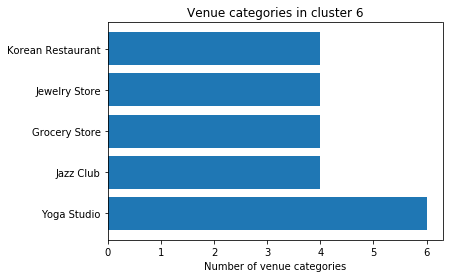

In [27]:

#count venue categories in all neighborhoods in the cluster
t6 = total_venue_categories(toronto_merged[toronto_merged['Cluster Labels'] == 6])

y_pos = np.arange(len(t6['Venue Category']))
plt.barh(y_pos, t6['Venue Count'], align='center')
plt.yticks(y_pos, t6['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 6')
 
plt.show()

We will generate list of 5 most appearing venues in least common venues and plot a bar graph showing the investor which venue type he can choose in second cluster to start a new business

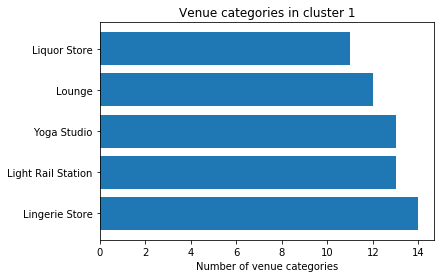

In [28]:
#count venue categories in all neighborhoods in the cluster
t1 = total_venue_categories(toronto_merged[toronto_merged['Cluster Labels'] == 1])

y_pos = np.arange(len(t1['Venue Category']))
plt.barh(y_pos, t1['Venue Count'], align='center')
plt.yticks(y_pos, t1['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 1')
 
plt.show()